# Demo of RtDeep

We define a simple network using RtDeep with microcircuits.

Task: learn to reproduce output of a teacher network.

The model uses real time dynamics with Euler integration, LE, dendritic error propagation and a phased implementation of DTP-DRL and L-DRL.

## Definitions

In [1]:
%matplotlib widget

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=12,family='serif')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from microcircuit import *
import sys
# import pandas as pd


#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport microcircuit

## Learn $B = W^T$

We add tiny noise to the hidden layer in a network [1-2-1] and learn the backwards weights to align with $(W^\mathrm{PP})^T$.

In particular, to make it easiert to identify if the task is performed succesfully, we initialise $B^\mathrm{PP}$ with negative entries, and $(W^\mathrm{PP})^T$ with positive values.

### Setup

In [228]:
# simulation settings

dt     = 1e-4 # in ms
dtxi   = 10 * dt
tausyn = 100 * dt
Tpres  = 1e+4 * dt # present images for 1 ms
Tbw    = 1 * Tpres # time scale of phases for backward weight learning
Ttot   = 50 * Tpres # total simulation time

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * max(|uP|)
noise_scale = [5e-2]

In [204]:
np.random.seed(12345)

# Init model: weights, voltages

layers = [1, 2, 1]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [1000.0] * (len(layers) - 2)
eta_IP = [200.0] * (len(layers) - 1)
eta_PI = [50.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [1e-4]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i]))) # << init fw weights positively

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 0, size=(layers[i], layers[-1]))) # << init bw weights negatively

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))

In [205]:
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

In [206]:
mc1 = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, model='LDRL',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

# mc1.set_self_predicting_state()

In [207]:
# check that the low-pass filter on the interneuron is deactivated
mc1.inter_low_pass

False

In [227]:
# check that the high-pass filter on the pyramidal signal used in updates of BPP is deactivated
mc1.pyr_hi_pass

True

### Simulation

In [210]:
# # pre-training to settle voltages
# for i in range(len(r0_random)):
#     mc1.evolve_system(r0=r0_random[i], learn_weights=False, learn_bw_weights=False)

In [211]:
u_time_series = []
uIbreve_time_series = []
uPbreve_time_series = []
rIbreve_time_series = []
rPbreve_time_series = []
xibreve_time_series = []

WPP_time_series = []
BPP_time_series = []
WIP_time_series = []
BPI_time_series = []
dBPP_time_series = []
vapi_time_series = []

for i in range(len(r0_random)):
    mc1.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
    # mc1.set_self_predicting_state()
    
    uIbreve_time_series.append(copy.deepcopy(mc1.uI_breve))
    uPbreve_time_series.append(copy.deepcopy(mc1.uP_breve))
    rIbreve_time_series.append(copy.deepcopy(mc1.rI_breve))
    rPbreve_time_series.append(copy.deepcopy(mc1.rP_breve))
    u_time_series.append(copy.deepcopy(mc1.get_voltages()))

    vapi_time_series.append(copy.deepcopy(mc1.vapi))
    xibreve_time_series.append(copy.deepcopy(mc1.noise_breve))
    WPP, WIP, BPP, BPI = mc1.get_weights()
    WPP_time_series.append(copy.deepcopy(WPP))
    BPP_time_series.append(copy.deepcopy(BPP))
    WIP_time_series.append(copy.deepcopy(WIP))
    BPI_time_series.append(copy.deepcopy(BPI))
    
    dBPP_time_series.append(copy.deepcopy(mc1.dBPP))
        
uP_time_series = [u[0] for u in u_time_series]
uI_time_series = [u[1] for u in u_time_series]

Current time: 0s
Learning backward weights to layer 1
Current time: 1.0s
Learning backward weights to layer 1
Current time: 2.0s
Learning backward weights to layer 1
Current time: 3.0s
Learning backward weights to layer 1
Current time: 4.0s
Learning backward weights to layer 1
Current time: 5.0s
Learning backward weights to layer 1
Current time: 6.0s
Learning backward weights to layer 1
Current time: 7.0s
Learning backward weights to layer 1
Current time: 8.0s
Learning backward weights to layer 1
Current time: 9.0s
Learning backward weights to layer 1
Current time: 10.0s
Learning backward weights to layer 1
Current time: 11.0s
Learning backward weights to layer 1
Current time: 12.0s
Learning backward weights to layer 1
Current time: 13.0s
Learning backward weights to layer 1
Current time: 14.0s
Learning backward weights to layer 1
Current time: 15.0s
Learning backward weights to layer 1
Current time: 16.0s
Learning backward weights to layer 1
Current time: 17.0s
Learning backward weigh

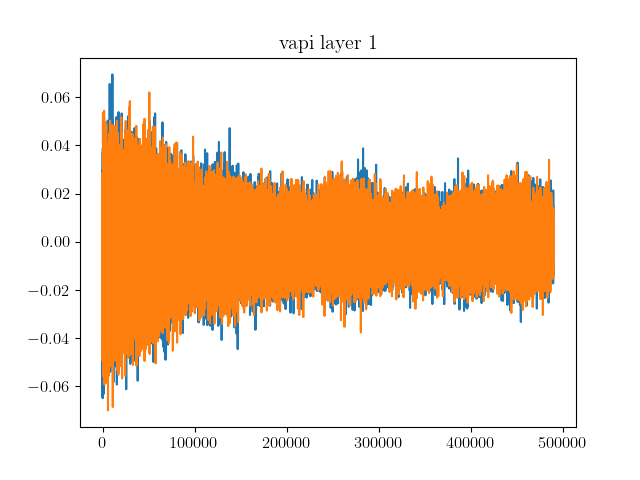

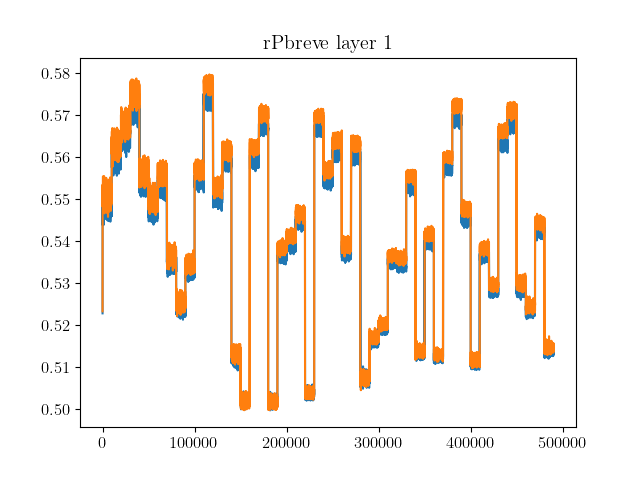

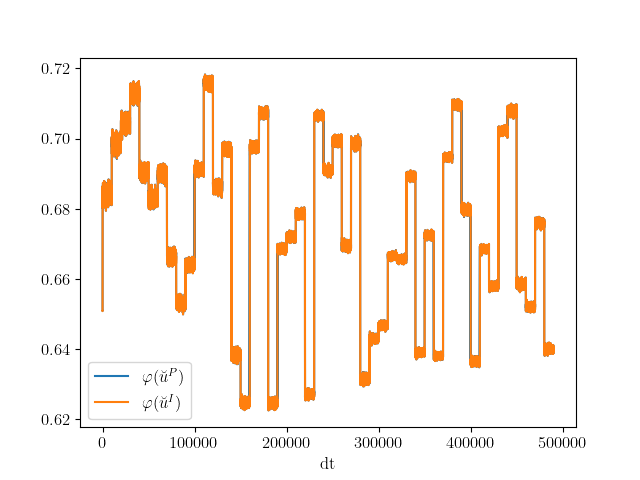

In [212]:
fig = plt.figure()
rP = [rP[0][0] for rP in vapi_time_series]
plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
rP = [rP[0][1] for rP in vapi_time_series]
plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
plt.title("vapi layer 1")
plt.show()

fig = plt.figure()
rP = [rP[0][0] for rP in rPbreve_time_series]
plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
rP = [rP[0][1] for rP in rPbreve_time_series]
plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
plt.title("rPbreve layer 1")
plt.show()

fig = plt.figure()
rP = [rP[1] for rP in rPbreve_time_series]
plt.plot(np.array(rP[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^P)}$")
plt.plot(np.array(rIbreve_time_series[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^I)}$")
plt.legend()
# plt.gca().set_xlim(left=int(Tpres/dt))
plt.xlabel('dt')
plt.show()


# fig = plt.figure()
# xibreve = [xibreve[0] for xibreve in xibreve_time_series]
# plt.plot(np.array(xibreve[0*int(Tpres/dt):]), label=["$\\breve{\\xi_1}$","$\\breve{\\xi_2}$"])
# plt.title("Lookahead of noise")
# plt.xlabel('dt')
# plt.legend()
# plt.show()

Now, let's also check that BPI has converged onto -BPP and WIP onto WPP:

In [220]:
cos_BPI_BPP = []
for i in range(len(BPI_time_series[0])):
    cos_BPI_BPP.append(np.array([
        cos_sim(BPI_time_series[j][i], -BPP_time_series[j][i]) for j in range(0, len(BPI_time_series), 10)
                           ]))
    
cos_WIP_WPP = []
for i in range(len(WIP_time_series[0])):
    cos_WIP_WPP.append(np.array([
        cos_sim(WIP_time_series[j][i], WPP_time_series[j][i+1]) for j in range(0, len(WIP_time_series), 10)
                           ]))
    
cos_WPPtrans_BPP = []
for i in range(len(BPP_time_series[0])):
    cos_WPPtrans_BPP.append(np.array([
        cos_sim(BPP_time_series[j][i], WPP_time_series[j][i+1].T) for j in range(0, len(BPP_time_series), 10)
                           ]))

BPP at init:

In [221]:
BPP_time_series[0][0]

array([[-0.25274814],
       [-0.03776449]])

BPP after learning:

In [222]:
BPP_time_series[-1][0]

array([[0.02947801],
       [0.02169182]])

WPP^T (fixed):

In [223]:
WPP_time_series[0][1].T

array([[0.96451452],
       [0.6531771 ]])

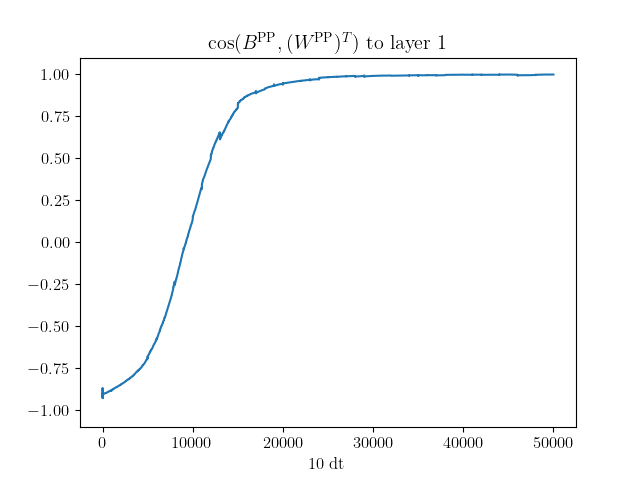

In [224]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WPPtrans_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^T)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    

# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1].T for WPP in WPP_time_series]).ravel(), label="WPP.T")
# ax.plot(np.array(BPP_time_series).ravel(), label="BPP")
# plt.yscale('linear')
# label = 'dt'
# plt.xlabel(label)
# plt.ylabel("B")
# plt.legend()
# # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
# plt.show()

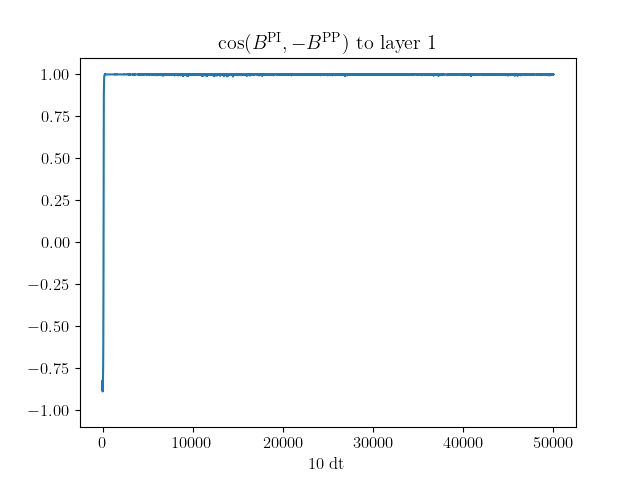

In [225]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_BPI_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    

# fig, ax = plt.subplots()
# ax.plot(np.array(BPI_time_series).ravel(), label="BPI")
# ax.plot(-np.array(BPP_time_series).ravel(), label="BPP")
# plt.yscale('linear')
# label = 'dt'
# plt.xlabel(label)
# plt.ylabel("B")
# plt.legend()
# # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
# plt.show()

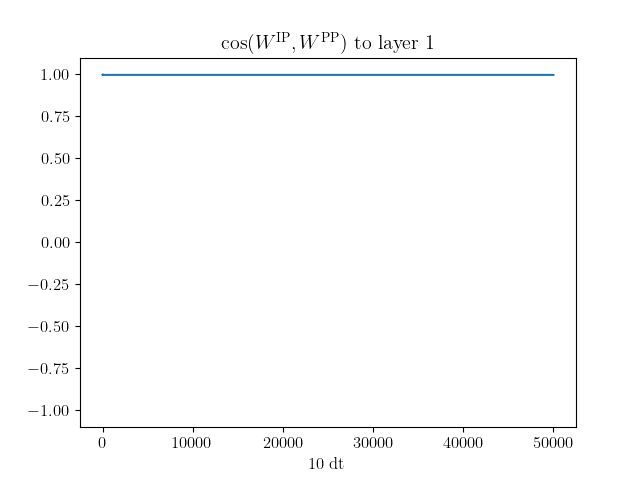

In [226]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WIP_WPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()


# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
# ax.plot(np.array(WIP_time_series).ravel())
# plt.yscale('linear')
# label = 'dt'
# # plt.legend()
# plt.xlabel(label)
# plt.show()

## Learn $B = W^T$

We make another example with a network of size [2-2-2].

### Setup

In [266]:
# simulation settings

dt     = 1e-4 # in ms
dtxi   = 10 * dt
tausyn = 100 * dt
Tpres  = 1e+4 * dt
Tbw    = 1 * Tpres # time scale of phases for backward weight learning
Ttot   = 100 * Tpres # total simulation time

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * max(|uP|)
noise_scale = [5*1e-2]

In [282]:
np.random.seed(12345)

# Init model: weights, voltages

layers = [2, 2, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [1000.0] * (len(layers) - 2)
eta_IP = [200.0] * (len(layers) - 1)
eta_PI = [50.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [1e-4]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    

INIT_CONST = 1
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, INIT_CONST, size=(layers[i+1], layers[i])))

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-INIT_CONST, INIT_CONST, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-INIT_CONST, 0, size=(layers[i], layers[-1])))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-INIT_CONST, INIT_CONST, size=(layers[i], layers[-1])))

In [283]:
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(-1, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

In [284]:
mc2 = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, model='LDRL',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc2.set_self_predicting_state()

In [285]:
mc2.WPP[1]

array([[0.74771481, 0.96130674],
       [0.0083883 , 0.10644438]])

### Simulation

In [286]:
u_time_series = []
uIbreve_time_series = []
uPbreve_time_series = []
rIbreve_time_series = []
rPbreve_time_series = []
rPbreve_HI_time_series = []
xibreve_time_series = []
vapi_time_series = []

WPP_time_series = []
BPP_time_series = []
WIP_time_series = []
BPI_time_series = []
dBPP_time_series = []

for i in range(len(r0_random)):
    mc2.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
    
    rIbreve_time_series.append(copy.deepcopy(mc2.rI_breve))
    rPbreve_time_series.append(copy.deepcopy(mc2.rP_breve))
    u_time_series.append(copy.deepcopy(mc2.get_voltages()))
    vapi_time_series.append(copy.deepcopy(mc2.vapi))

    rPbreve_HI_time_series.append(copy.deepcopy(mc2.rP_breve_HI))
    xibreve_time_series.append(copy.deepcopy(mc2.noise_breve))
    WPP, WIP, BPP, BPI = mc2.get_weights()
    WPP_time_series.append(copy.deepcopy(WPP))
    BPP_time_series.append(copy.deepcopy(BPP))
    WIP_time_series.append(copy.deepcopy(WIP))
    BPI_time_series.append(copy.deepcopy(BPI))
        
uP_time_series = [u[0] for u in u_time_series]
uI_time_series = [u[1] for u in u_time_series]

Current time: 0s
Learning backward weights to layer 1
Current time: 1.0s
Learning backward weights to layer 1
Current time: 2.0s
Learning backward weights to layer 1
Current time: 3.0s
Learning backward weights to layer 1
Current time: 4.0s
Learning backward weights to layer 1
Current time: 5.0s
Learning backward weights to layer 1
Current time: 6.0s
Learning backward weights to layer 1
Current time: 7.0s
Learning backward weights to layer 1
Current time: 8.0s
Learning backward weights to layer 1
Current time: 9.0s
Learning backward weights to layer 1
Current time: 10.0s
Learning backward weights to layer 1
Current time: 11.0s
Learning backward weights to layer 1
Current time: 12.0s
Learning backward weights to layer 1
Current time: 13.0s
Learning backward weights to layer 1
Current time: 14.0s
Learning backward weights to layer 1
Current time: 15.0s
Learning backward weights to layer 1
Current time: 16.0s
Learning backward weights to layer 1
Current time: 17.0s
Learning backward weigh

In [287]:
# # fig = plt.figure()
# # rP = [rP[0] for rP in rPbreve_time_series]
# # plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# # plt.show()

# fig = plt.figure()
# rP = [rP[1] for rP in rPbreve_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^P)}$")
# plt.plot(np.array(rIbreve_time_series[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^I)}$")
# plt.legend()
# plt.title("Denoising in interneuron")
# plt.xlabel('dt')
# plt.show()


# fig = plt.figure()
# rPbreve_HI = [rPbreve_HI[1] for rPbreve_HI in rPbreve_HI_time_series]
# plt.plot(np.array(rPbreve_HI[int(Tpres/dt):]).ravel(), label="$\widehat{\\varphi{(\\breve{u}^P)}}$")
# plt.xlabel('dt')
# plt.title("High-pass filtering")
# plt.legend()
# plt.show()

# fig = plt.figure()
# xibreve = [xibreve[0] for xibreve in xibreve_time_series]
# plt.plot(np.array(xibreve[int(Tpres/dt):]), label=["$\\breve{\\xi_1}$","$\\breve{\\xi_2}$"])
# plt.title("Lookahead of noise")
# plt.xlabel('dt')
# plt.legend()
# plt.show()

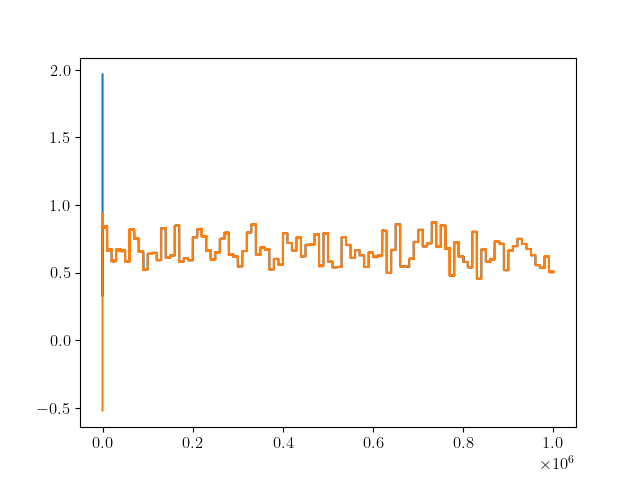

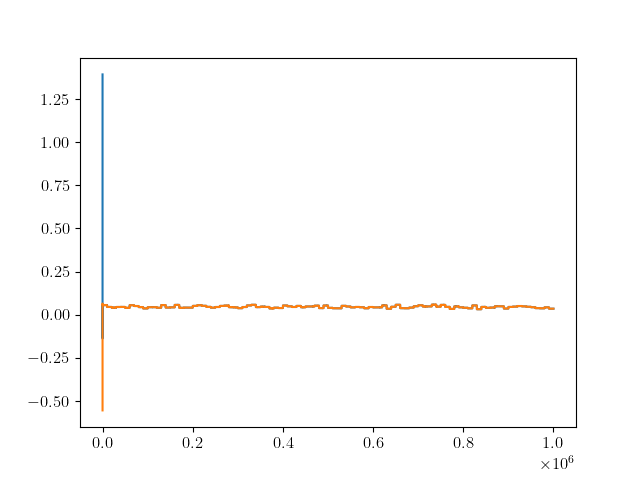

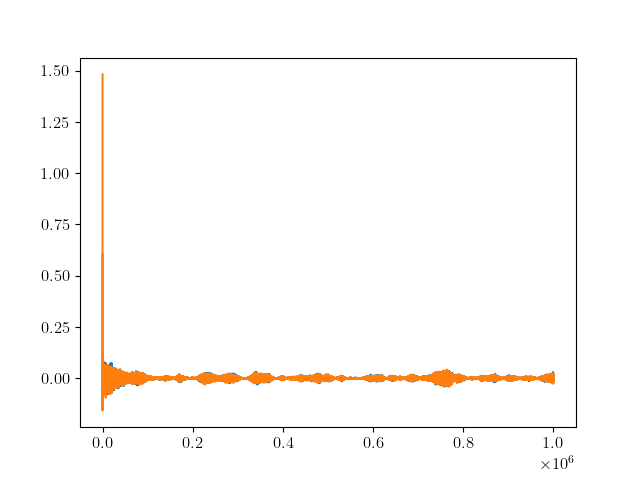

In [288]:
for i in range(layers[-1]):
    
    # plot neuron outputs in output layer

    fig = plt.figure()
    plt.plot(np.array(rIbreve_time_series).T[i][0])
    plt.plot(np.array(rPbreve_time_series).T[i][1])
    plt.show()
    
# check apical potentials

fig = plt.figure()
plt.plot(np.array(vapi_time_series).T[0][0])
plt.plot(np.array(vapi_time_series).T[1][0])
plt.show()


Now, let's also check that BPI has converged onto -BPP and WIP onto WPP:

In [289]:
cos_BPI_BPP = []
for i in range(len(BPI_time_series[0])):
    cos_BPI_BPP.append(np.array([
        cos_sim(BPI_time_series[j][i], -BPP_time_series[j][i]) for j in range(0, len(BPI_time_series), 10)
                           ]))
    
cos_rIbreveBPI_rPbreveBPP = []
for i in range(len(BPI_time_series[0])):
    cos_rIbreveBPI_rPbreveBPP.append(np.array([
        cos_sim(BPI_time_series[j][i] @ rIbreve_time_series[j][i], -BPP_time_series[j][i] @ rPbreve_time_series[j][i]) for j in range(0, len(BPI_time_series), 10)
                           ]))
    
cos_WIP_WPP = []
for i in range(len(WIP_time_series[0])):
    cos_WIP_WPP.append(np.array([
        cos_sim(WIP_time_series[j][i], WPP_time_series[j][i+1]) for j in range(0, len(WIP_time_series), 10)
                           ]))
    
cos_WPPtrans_BPP = []
for i in range(len(BPP_time_series[0])):
    cos_WPPtrans_BPP.append(np.array([
        cos_sim(BPP_time_series[j][i], WPP_time_series[j][i+1].T) for j in range(0, len(BPP_time_series), 10)
                           ]))

BPP at init:

In [290]:
BPP_time_series[0][0]

array([[-0.03421102, -0.27509114],
       [-0.35968246, -0.28485592]])

BPP after learning:

In [291]:
BPP_time_series[-1][0]

array([[ 4.04979126e-03, -7.89895241e-05],
       [ 8.00378150e-03,  8.92944588e-04]])

WPP^T (fixed):

In [292]:
WPP_time_series[0][1].T

array([[0.74771481, 0.0083883 ],
       [0.96130674, 0.10644438]])

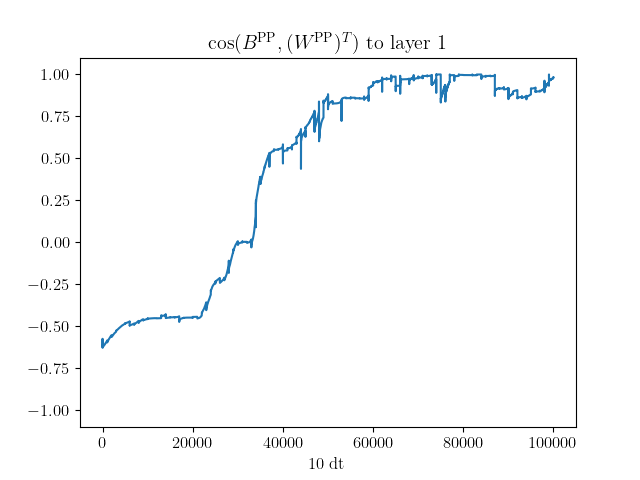

In [293]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WPPtrans_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^T)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    

# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1].T for WPP in WPP_time_series]).ravel(), label="WPP.T")
# ax.plot(np.array(BPP_time_series).ravel(), label="BPP")
# plt.yscale('linear')
# label = 'dt'
# plt.xlabel(label)
# plt.ylabel("B")
# plt.legend()
# # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
# plt.show()

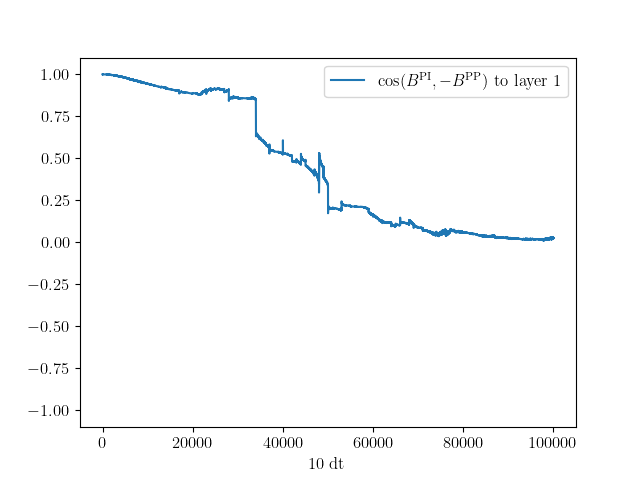

In [294]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_BPI_BPP[i], label='$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    # ax.plot(cos_rIbreveBPI_rPbreveBPP[i], label='$\cos(r^\mathrm{PI}, -r^\mathrm{PP})$ to layer ' + str(i+1))
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.legend()
    plt.ylim(-1.1,1.1)
    plt.show()
    

# fig, ax = plt.subplots()
# ax.plot(np.array(BPI_time_series).ravel(), label="BPI")
# ax.plot(-np.array(BPP_time_series).ravel(), label="BPP")
# plt.yscale('linear')
# label = 'dt'
# plt.xlabel(label)
# plt.ylabel("B")
# plt.legend()
# # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
# plt.show()

In [295]:
mc1.BPP

[array([[0.02947801],
        [0.02169182]])]

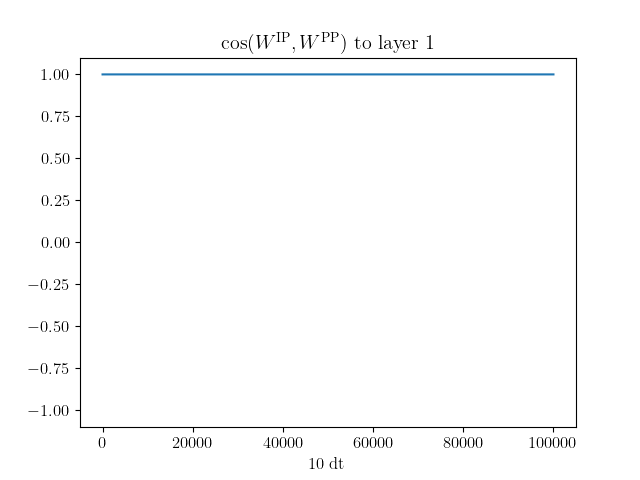

In [296]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WIP_WPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()


# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
# ax.plot(np.array(WIP_time_series).ravel())
# plt.yscale('linear')
# label = 'dt'
# # plt.legend()
# plt.xlabel(label)
# plt.show()

# Learn $W$ and $B$ simulataneously

In this example, we construct a teacher and try to learn the same weights in 3 students, using, LDRL, BP and FA.

Net: [1-1-2]. Reason: if the hidden layer is a single neuron, there is no ambiguity as to when the 'correct' weights $W^\mathrm{PP}$ are learnt — the task is only learnt successfully if $W^\mathrm{PP}$ matches the teacher exactly.

In order to get a clear difference between the models, we initialise $W^\mathrm{PP}$ to hidden layer of the students with opposite signs as the teacher. We also fix all $W^\mathrm{PP}$ to the output layer to the same value as the teacher.

The self-predicting state is calculated dynamically, after setting it once at the beginning.

### Setup

In [59]:
# simulation settings

dt     = 1e-3 # in ms
dtxi   = 10 * dt
tausyn = 100 * dt
Tpres  = 1e+3 * dt # present images for 1 ms
Tbw    = 1 * Tpres # time scale of phases for backward weight learning
Ttot   = 1000 * Tpres # total simulation time

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * max(|uP|)
noise_scale = [5e-2]

In [60]:
np.random.seed(9876)

# Init model: weights, voltages

layers = [1, 1, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [0.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1)
eta_PI = [0.0] * (len(layers) - 1)

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 2, size=(layers[i+1], layers[i]))) # << init fw weights positively

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-2, 2, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(0, 2, size=(layers[i], layers[-1]))) # << don't matter, get set to W.T anyways

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-2, 2, size=(layers[i], layers[-1])))
    
    
    
mc3_teacher = base_model(dt, Tpres, model='BP',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc3_teacher.set_self_predicting_state()

In [61]:
np.random.seed(1234)

# Init model: weights, voltages

layers = [1, 1, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [200.0, 0]
eta_bw = [100.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1)
eta_PI = [5.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [0e-4]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]

# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-2):
    WPP_init.append(np.random.uniform(-2, 0, size=(layers[i+1], layers[i]))) # << init fw weights netatively
    WPP_init.append(mc3_teacher.WPP[1])

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-2, 2, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-2, 0, size=(layers[i], layers[-1]))) # << init bw weights negatively

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-2, 2, size=(layers[i], layers[-1])))

In [62]:
mc3_student = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, model='LDRL',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc3_student.set_self_predicting_state()

In [63]:
mc3_student_BP = base_model(dt, Tpres, model='BP',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc3_student_BP.set_self_predicting_state()

In [64]:
mc3_student_FA = base_model(dt, Tpres, model='FA',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc3_student_FA.set_self_predicting_state()

In [65]:
# check that student and teacher are not aligned already
cos_sim(mc3_student_BP.WPP[0], mc3_teacher.WPP[0])

-0.9999999999999999

In [66]:
# we have set WPP to output layer equal in all models
mc3_student_BP.WPP

[array([[-1.44707149]]),
 array([[0.27375306],
        [1.89765152]])]

In [67]:
mc3_teacher.WPP

[array([[0.91962473]]),
 array([[0.27375306],
        [1.89765152]])]

### Simulation

In [68]:
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

# u2P of teacher will be target for student
target_time_series = []

# a little pre-training: run for one Tpres with random input, such that the
# somatic voltages converge
for i in range(int(Tpres/dt)):
    mc3_teacher.evolve_system(r0=r0_random[i])

# run real evaluation and save output
for i in range(len(r0_random)):
    mc3_teacher.evolve_system(r0=r0_random[i])
    target_time_series.append(copy.deepcopy(mc3_teacher.uP_breve[1]))

target_time_series = np.array(target_time_series)

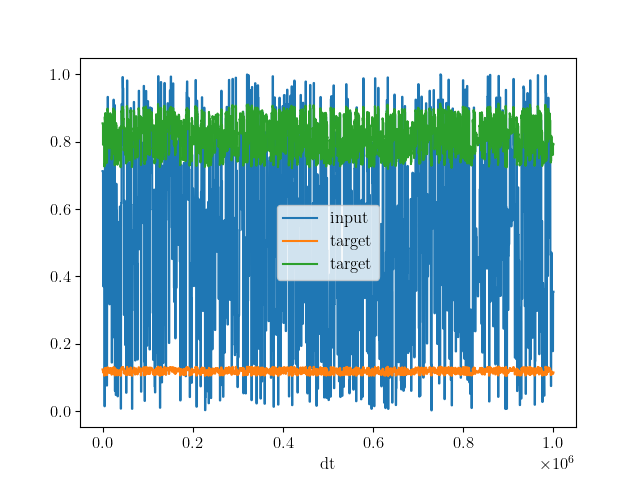

In [69]:
fig = plt.figure()
plt.plot(r0_random, label='input')
plt.plot(target_time_series, label='target')
plt.xlabel("dt")
plt.legend()
plt.show()

In [70]:
WPP_FA_time_series = []

for i in range(len(r0_random)):
    mc3_student_FA.evolve_system(r0=r0_random[i], u_tgt=[target_time_series[i]]) # << adapt WIP, BPI and BPP
    
    WPP_FA_time_series.append(copy.deepcopy(mc3_student_FA.WPP))

In [71]:
WPP_BP_time_series = []
BPP_BP_time_series = []

for i in range(len(r0_random)):
    mc3_student_BP.evolve_system(r0=r0_random[i], u_tgt=[target_time_series[i]]) # << adapt WIP, BPI and BPP
    
    WPP_BP_time_series.append(copy.deepcopy(mc3_student_BP.WPP))
    BPP_BP_time_series.append(copy.deepcopy(mc3_student_BP.BPP))

In [72]:
u_time_series = []
uIbreve_time_series = []
uPbreve_time_series = []
rIbreve_time_series = []
rPbreve_time_series = []

WPP_time_series = []
BPP_time_series = []
WIP_time_series = []
BPI_time_series = []
dBPP_time_series = []
vapi_time_series = []

for i in range(len(r0_random)):
    mc3_student.evolve_system(r0=r0_random[i], u_tgt=[target_time_series[i]], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
    # mc3_student.set_self_predicting_state()
    
    rIbreve_time_series.append(copy.deepcopy(mc3_student.rI_breve))
    rPbreve_time_series.append(copy.deepcopy(mc3_student.rP_breve))
    u_time_series.append(copy.deepcopy(mc3_student.get_voltages()))

    vapi_time_series.append(copy.deepcopy(mc3_student.vapi))
    WPP, WIP, BPP, BPI = mc3_student.get_weights()
    WPP_time_series.append(copy.deepcopy(WPP))
    BPP_time_series.append(copy.deepcopy(BPP))
    WIP_time_series.append(copy.deepcopy(WIP))
    BPI_time_series.append(copy.deepcopy(BPI))

uP_time_series = [u[0] for u in u_time_series]
uI_time_series = [u[1] for u in u_time_series]

Current time: 0s
Learning backward weights to layer 1
Current time: 1.0s
Learning backward weights to layer 1
Current time: 2.0s
Learning backward weights to layer 1
Current time: 3.0s
Learning backward weights to layer 1
Current time: 4.0s
Learning backward weights to layer 1
Current time: 5.0s
Learning backward weights to layer 1
Current time: 6.0s
Learning backward weights to layer 1
Current time: 7.0s
Learning backward weights to layer 1
Current time: 8.0s
Learning backward weights to layer 1
Current time: 9.0s
Learning backward weights to layer 1
Current time: 10.0s
Learning backward weights to layer 1
Current time: 11.0s
Learning backward weights to layer 1
Current time: 12.0s
Learning backward weights to layer 1
Current time: 13.0s
Learning backward weights to layer 1
Current time: 14.0s
Learning backward weights to layer 1
Current time: 15.0s
Learning backward weights to layer 1
Current time: 16.0s
Learning backward weights to layer 1
Current time: 17.0s
Learning backward weigh

In [73]:
# fig = plt.figure()
# rP = [rP[0][0] for rP in vapi_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# rP = [rP[0][1] for rP in vapi_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# plt.title("vapi layer 1")
# plt.show()

# fig = plt.figure()
# rP = [rP[0][0] for rP in rPbreve_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# rP = [rP[0][1] for rP in rPbreve_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# plt.title("rPbreve layer 1")
# plt.show()

# fig = plt.figure()
# rP = [rP[1] for rP in rPbreve_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^P)}$")
# plt.plot(np.array(rIbreve_time_series[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^I)}$")
# plt.legend()
# # plt.gca().set_xlim(left=int(Tpres/dt))
# plt.xlabel('dt')
# plt.show()


# # fig = plt.figure()
# # xibreve = [xibreve[0] for xibreve in xibreve_time_series]
# # plt.plot(np.array(xibreve[0*int(Tpres/dt):]), label=["$\\breve{\\xi_1}$","$\\breve{\\xi_2}$"])
# # plt.title("Lookahead of noise")
# # plt.xlabel('dt')
# # plt.legend()
# # plt.show()

Now, let's also check that BPI has converged onto -BPP and WIP onto WPP:

In [74]:
cos_WPPteacher_WPPstudentFA = []
for i in range(0,len(WPP_time_series[0])):
    cos_WPPteacher_WPPstudentFA.append(np.array([
        cos_sim(mc3_teacher.WPP[i], WPP_FA_time_series[j][i]) for j in range(0, len(WPP_time_series), 10)
                           ]))
    
cos_WPPteacher_WPPstudentBP = []
for i in range(0,len(WPP_time_series[0])):
    cos_WPPteacher_WPPstudentBP.append(np.array([
        cos_sim(mc3_teacher.WPP[i], WPP_BP_time_series[j][i]) for j in range(0, len(WPP_time_series), 10)
                           ]))

cos_WPPteacher_WPPstudent = []
for i in range(0,len(WPP_time_series[0])):
    cos_WPPteacher_WPPstudent.append(np.array([
        cos_sim(mc3_teacher.WPP[i], WPP_time_series[j][i]) for j in range(0, len(WPP_time_series), 10)
                           ]))
    
cos_BPI_BPP = []
for i in range(len(BPI_time_series[0])):
    cos_BPI_BPP.append(np.array([
        cos_sim(BPI_time_series[j][i], -BPP_time_series[j][i]) for j in range(0, len(BPI_time_series), 10)
                           ]))
    
cos_WIP_WPP = []
for i in range(len(WIP_time_series[0])):
    cos_WIP_WPP.append(np.array([
        cos_sim(WIP_time_series[j][i], WPP_time_series[j][i+1]) for j in range(0, len(WIP_time_series), 10)
                           ]))
    
cos_WPPtrans_BPP = []
for i in range(len(BPP_time_series[0])):
    cos_WPPtrans_BPP.append(np.array([
        cos_sim(BPP_time_series[j][i], WPP_time_series[j][i+1].T) for j in range(0, len(BPP_time_series), 10)
                           ]))

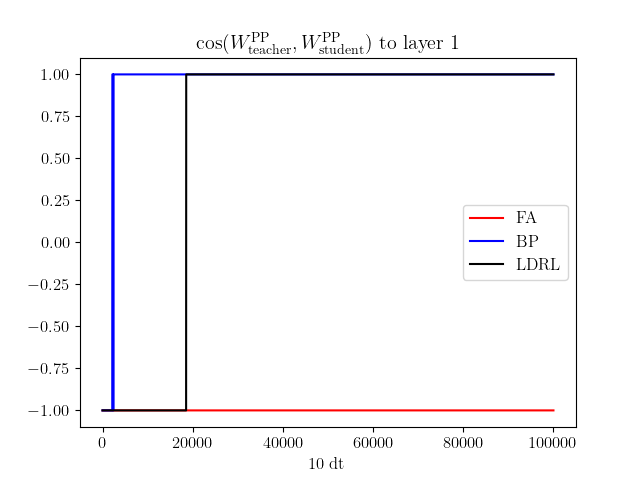

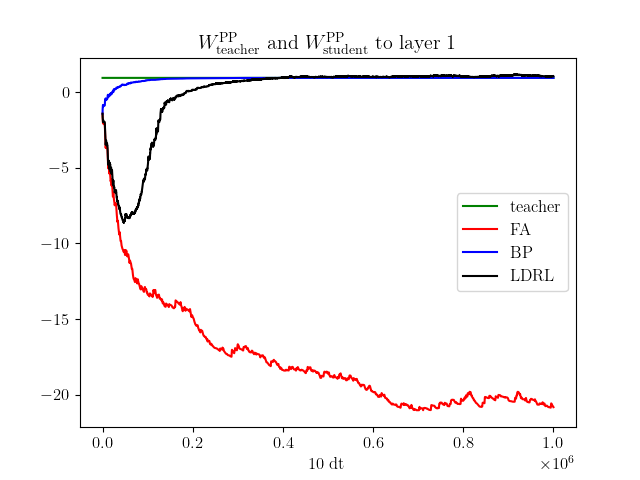

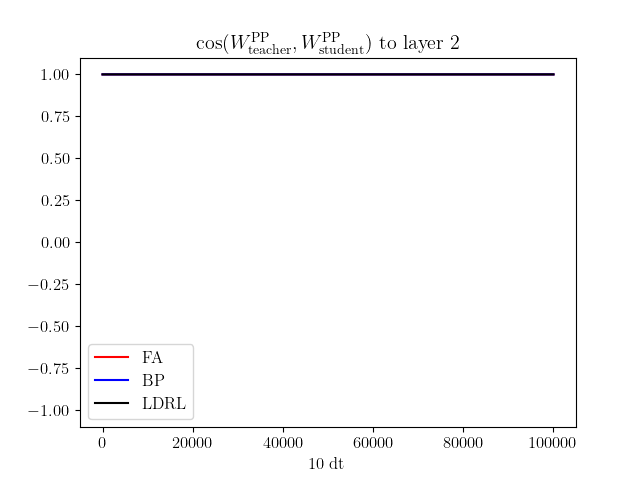

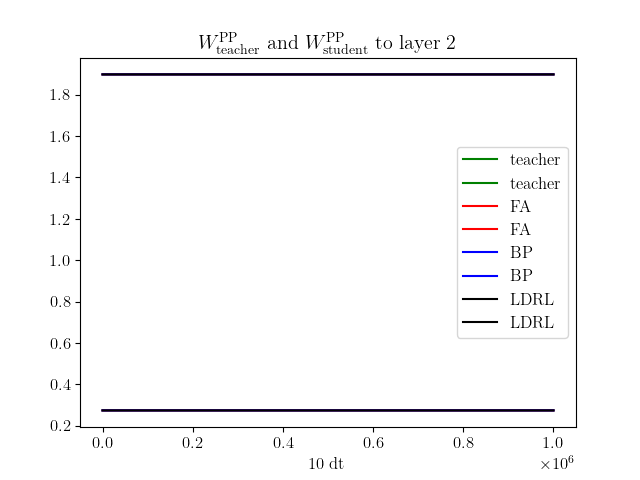

In [75]:
for i in range(len(layers[0:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WPPteacher_WPPstudentFA[i], label="FA", c='red')
    ax.plot(cos_WPPteacher_WPPstudentBP[i], label="BP", c='blue')
    ax.plot(cos_WPPteacher_WPPstudent[i], label="LDRL", c='black')
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{PP}_\mathrm{teacher}, W^\mathrm{PP}_\mathrm{student})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([mc3_teacher.WPP[i].ravel() for WPP in WPP_FA_time_series], label="teacher", c='green')
    ax.plot([WPP[i].ravel() for WPP in WPP_FA_time_series], label="FA", c='red')
    ax.plot([WPP[i].ravel() for WPP in WPP_BP_time_series], label="BP", c='blue')
    ax.plot([WPP[i].ravel() for WPP in WPP_time_series], label="LDRL", c='black')
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$W^\mathrm{PP}_\mathrm{teacher}$ and $W^\mathrm{PP}_\mathrm{student}$ to layer ' + str(i+1))
    # plt.ylim(-1.1,1.1)
    plt.legend()
    plt.show()
    

# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1].T for WPP in WPP_time_series]).ravel(), label="WPP.T")
# ax.plot(np.array(BPP_time_series).ravel(), label="BPP")
# plt.yscale('linear')
# label = 'dt'
# plt.xlabel(label)
# plt.ylabel("B")
# plt.legend()
# # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
# plt.show()

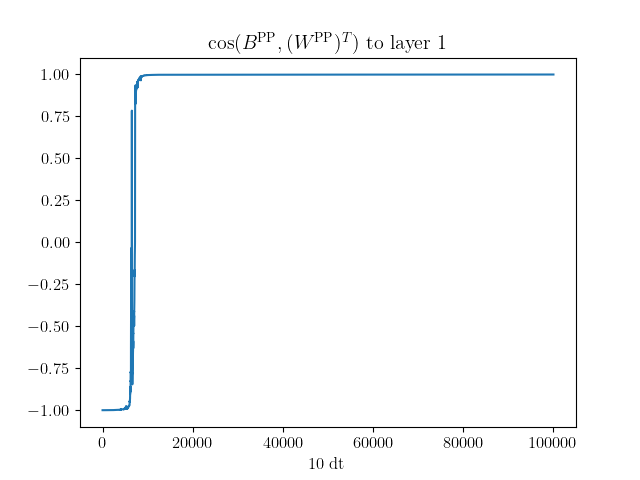

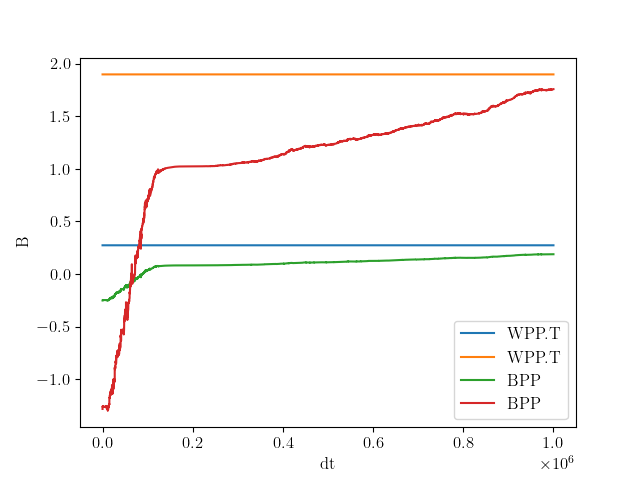

In [76]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WPPtrans_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^T)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    
    fig, ax = plt.subplots()
    ax.plot([WPP[i+1].T.ravel() for WPP in WPP_time_series], label="WPP.T")
    ax.plot([BPP[i].ravel() for BPP in BPP_time_series], label="BPP")
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

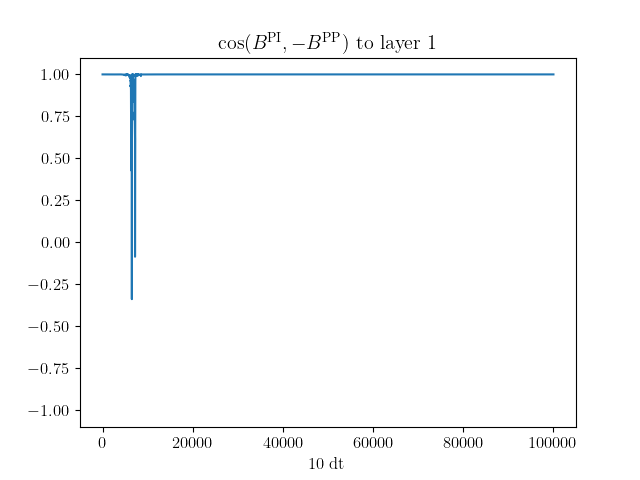

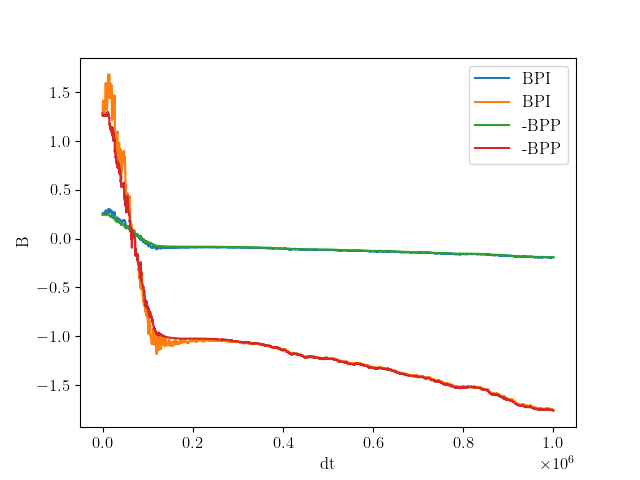

In [77]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_BPI_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([BPI[i].ravel() for BPI in BPI_time_series], label="BPI")
    ax.plot([-BPP[i].ravel() for BPP in BPP_time_series], label="-BPP")
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

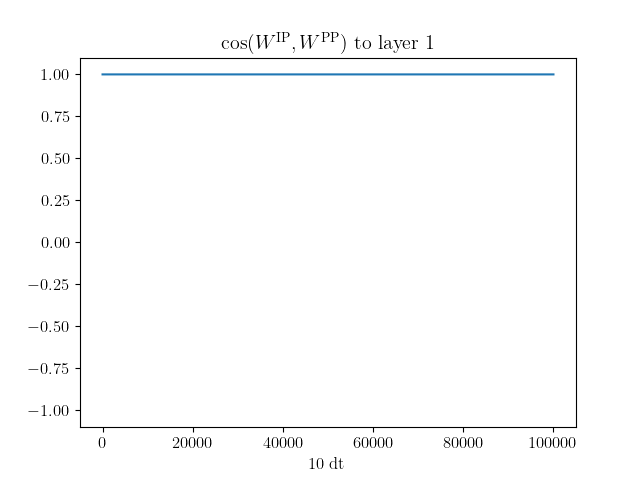

In [78]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WIP_WPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()


# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
# ax.plot(np.array(WIP_time_series).ravel())
# plt.yscale('linear')
# label = 'dt'
# # plt.legend()
# plt.xlabel(label)
# plt.show()

# Learn $W$ and $B$ simulataneously

Same as before, but net is now [2-2-2].

We also increase the scale of dt by a factor of 2 to speed up simulation.

### Setup

In [280]:
# simulation settings

dt     = 2e-3 # in ms
dtxi   = 5 * dt
tausyn = 10 * dtxi
Tpres  = 1/dt * dt # present images for 1 ms
Tbw    = 1 * Tpres # time scale of phases for backward weight learning
Ttot   = 500 * Tpres # total simulation time

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * max(|uP|)
noise_scale = [5e-2]

In [281]:
np.random.seed(9876)

# Init model: weights, voltages

layers = [2, 2, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [0.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1)
eta_PI = [0.0] * (len(layers) - 1)

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 2, size=(layers[i+1], layers[i]))) # << init fw weights positively

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-2, 2, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(0, 2, size=(layers[i], layers[-1]))) # << don't matter, get set to W.T anyways

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-2, 2, size=(layers[i], layers[-1])))
    
    
    
mc3_teacher = base_model(dt, Tpres, model='BP',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc3_teacher.set_self_predicting_state()

In [282]:
np.random.seed(123)

# Init model: weights, voltages

layers = [2, 2, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [500.0, 0]
eta_bw = [100.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1)
eta_PI = [5.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [1e-4]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]

# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-2):
    WPP_init.append(np.random.uniform(-2, 0, size=(layers[i+1], layers[i]))) # << init fw weights netatively
    WPP_init.append(mc3_teacher.WPP[1])

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-2, 2, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-2, 0, size=(layers[i], layers[-1]))) # << init bw weights negatively

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-2, 2, size=(layers[i], layers[-1])))

In [283]:
mc3_student = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, model='LDRL',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc3_student.set_self_predicting_state()

In [284]:
mc3_student_BP = base_model(dt, Tpres, model='BP',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc3_student_BP.set_self_predicting_state()

In [285]:
mc3_student_FA = base_model(dt, Tpres, model='FA',
                         activation=logistic, d_activation=d_logistic, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc3_student_FA.set_self_predicting_state()

In [286]:
# check that student and teacher are not aligned already
cos_sim(mc3_student_BP.WPP[0], mc3_teacher.WPP[0])

-0.8375646017387628

In [287]:
# we have set WPP to output layer equal in all models
mc3_student_BP.WPP

[array([[-0.0384716 , -0.63034052],
        [-1.0381362 , -1.21576496]]),
 array([[0.35638437, 0.29852035],
        [0.52691908, 0.58945149]])]

In [288]:
mc3_teacher.WPP

[array([[0.91962473, 0.27375306],
        [1.89765152, 0.9824115 ]]),
 array([[0.35638437, 0.29852035],
        [0.52691908, 0.58945149]])]

### Simulation

In [289]:
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

# u2P of teacher will be target for student
target_time_series = []

# a little pre-training: run for one Tpres with random input, such that the
# somatic voltages converge
for i in range(int(Tpres/dt)):
    mc3_teacher.evolve_system(r0=r0_random[i])

# run real evaluation and save output
for i in range(len(r0_random)):
    mc3_teacher.evolve_system(r0=r0_random[i])
    target_time_series.append(copy.deepcopy(mc3_teacher.uP_breve[1]))

target_time_series = np.array(target_time_series)

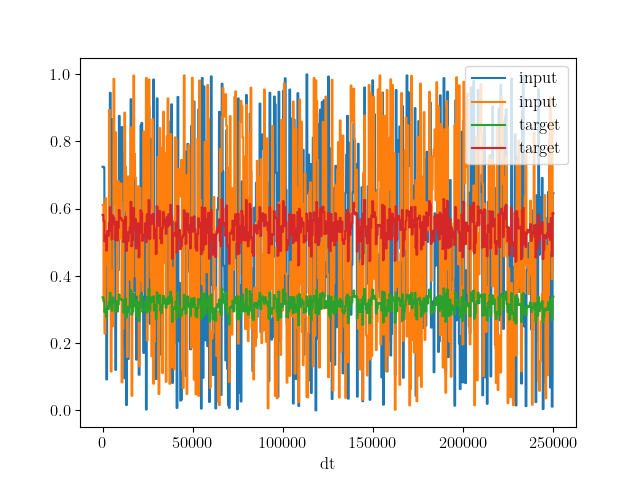

In [290]:
fig = plt.figure()
plt.plot(r0_random, label='input')
plt.plot(target_time_series, label='target')
plt.xlabel("dt")
plt.legend()
plt.show()

In [291]:
WPP_FA_time_series = []

for i in range(len(r0_random)):
    mc3_student_FA.evolve_system(r0=r0_random[i], u_tgt=[target_time_series[i]]) # << adapt WIP, BPI and BPP
    
    WPP_FA_time_series.append(copy.deepcopy(mc3_student_FA.WPP))

In [292]:
WPP_BP_time_series = []
BPP_BP_time_series = []

for i in range(len(r0_random)):
    mc3_student_BP.evolve_system(r0=r0_random[i], u_tgt=[target_time_series[i]]) # << adapt WIP, BPI and BPP
    
    WPP_BP_time_series.append(copy.deepcopy(mc3_student_BP.WPP))
    BPP_BP_time_series.append(copy.deepcopy(mc3_student_BP.BPP))

In [293]:
u_time_series = []
uIbreve_time_series = []
uPbreve_time_series = []
rIbreve_time_series = []
rPbreve_time_series = []

WPP_time_series = []
BPP_time_series = []
WIP_time_series = []
BPI_time_series = []
dBPP_time_series = []
vapi_time_series = []

for i in range(len(r0_random)):
    mc3_student.evolve_system(r0=r0_random[i], u_tgt=[target_time_series[i]], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
    # mc3_student.set_self_predicting_state()
    
    rIbreve_time_series.append(copy.deepcopy(mc3_student.rI_breve))
    rPbreve_time_series.append(copy.deepcopy(mc3_student.rP_breve))
    u_time_series.append(copy.deepcopy(mc3_student.get_voltages()))

    vapi_time_series.append(copy.deepcopy(mc3_student.vapi))
    WPP, WIP, BPP, BPI = mc3_student.get_weights()
    WPP_time_series.append(copy.deepcopy(WPP))
    BPP_time_series.append(copy.deepcopy(BPP))
    WIP_time_series.append(copy.deepcopy(WIP))
    BPI_time_series.append(copy.deepcopy(BPI))

uP_time_series = [u[0] for u in u_time_series]
uI_time_series = [u[1] for u in u_time_series]

Current time: 0s
Learning backward weights to layer 1
Current time: 1.0s
Learning backward weights to layer 1
Current time: 2.0s
Learning backward weights to layer 1
Current time: 3.0s
Learning backward weights to layer 1
Current time: 4.0s
Learning backward weights to layer 1
Current time: 5.0s
Learning backward weights to layer 1
Current time: 6.0s
Learning backward weights to layer 1
Current time: 7.0s
Learning backward weights to layer 1
Current time: 8.0s
Learning backward weights to layer 1
Current time: 9.0s
Learning backward weights to layer 1
Current time: 10.0s
Learning backward weights to layer 1
Current time: 11.0s
Learning backward weights to layer 1
Current time: 12.0s
Learning backward weights to layer 1
Current time: 13.0s
Learning backward weights to layer 1
Current time: 14.0s
Learning backward weights to layer 1
Current time: 15.0s
Learning backward weights to layer 1
Current time: 16.0s
Learning backward weights to layer 1
Current time: 17.0s
Learning backward weigh

In [300]:
# fig = plt.figure()
# rP = [rP[0][0] for rP in vapi_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# rP = [rP[0][1] for rP in vapi_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# plt.title("vapi layer 1")
# plt.show()

# fig = plt.figure()
# rP = [rP[0][0] for rP in rPbreve_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# rP = [rP[0][1] for rP in rPbreve_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# plt.title("rPbreve layer 1")
# plt.show()

# fig = plt.figure()
# rP = [rP[1] for rP in rPbreve_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^P)}$")
# plt.plot(np.array(rIbreve_time_series[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^I)}$")
# plt.legend()
# # plt.gca().set_xlim(left=int(Tpres/dt))
# plt.xlabel('dt')
# plt.show()


# # fig = plt.figure()
# # xibreve = [xibreve[0] for xibreve in xibreve_time_series]
# # plt.plot(np.array(xibreve[0*int(Tpres/dt):]), label=["$\\breve{\\xi_1}$","$\\breve{\\xi_2}$"])
# # plt.title("Lookahead of noise")
# # plt.xlabel('dt')
# # plt.legend()
# # plt.show()

Now, let's check that WPP has been learnt correctly:

In [295]:
cos_WPPteacher_WPPstudentFA = []
for i in range(0,len(WPP_time_series[0])):
    cos_WPPteacher_WPPstudentFA.append(np.array([
        cos_sim(mc3_teacher.WPP[i], WPP_FA_time_series[j][i]) for j in range(0, len(WPP_time_series), 10)
                           ]))
    
cos_WPPteacher_WPPstudentBP = []
for i in range(0,len(WPP_time_series[0])):
    cos_WPPteacher_WPPstudentBP.append(np.array([
        cos_sim(mc3_teacher.WPP[i], WPP_BP_time_series[j][i]) for j in range(0, len(WPP_time_series), 10)
                           ]))

cos_WPPteacher_WPPstudent = []
for i in range(0,len(WPP_time_series[0])):
    cos_WPPteacher_WPPstudent.append(np.array([
        cos_sim(mc3_teacher.WPP[i], WPP_time_series[j][i]) for j in range(0, len(WPP_time_series), 10)
                           ]))
    
cos_BPI_BPP = []
for i in range(len(BPI_time_series[0])):
    cos_BPI_BPP.append(np.array([
        cos_sim(BPI_time_series[j][i], -BPP_time_series[j][i]) for j in range(0, len(BPI_time_series), 10)
                           ]))
    
cos_WIP_WPP = []
for i in range(len(WIP_time_series[0])):
    cos_WIP_WPP.append(np.array([
        cos_sim(WIP_time_series[j][i], WPP_time_series[j][i+1]) for j in range(0, len(WIP_time_series), 10)
                           ]))
    
cos_WPPtrans_BPP = []
for i in range(len(BPP_time_series[0])):
    cos_WPPtrans_BPP.append(np.array([
        cos_sim(BPP_time_series[j][i], WPP_time_series[j][i+1].T) for j in range(0, len(BPP_time_series), 10)
                           ]))

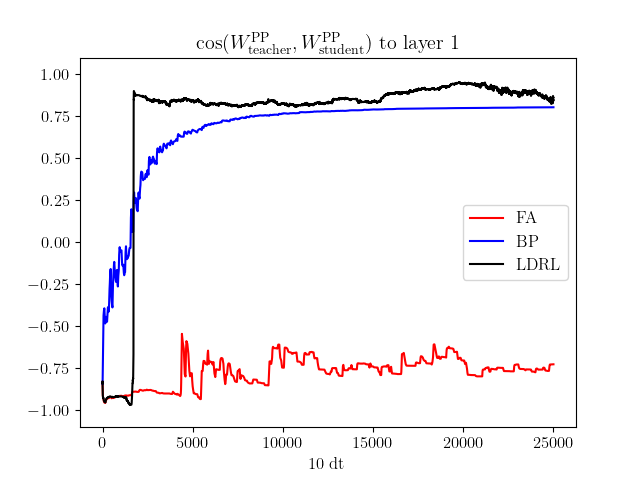

/Users/km/Software/anaconda3/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


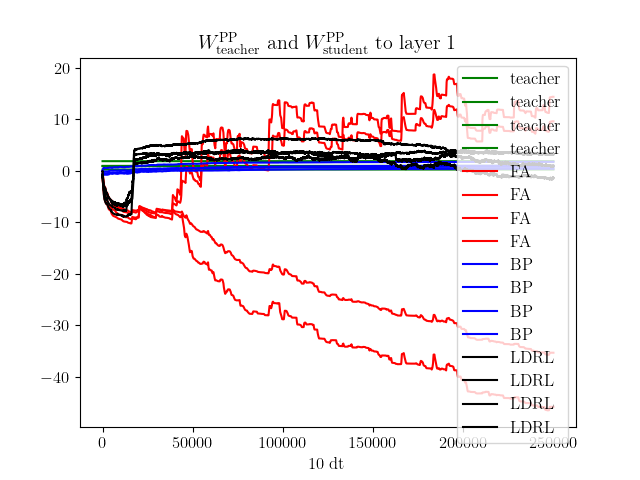

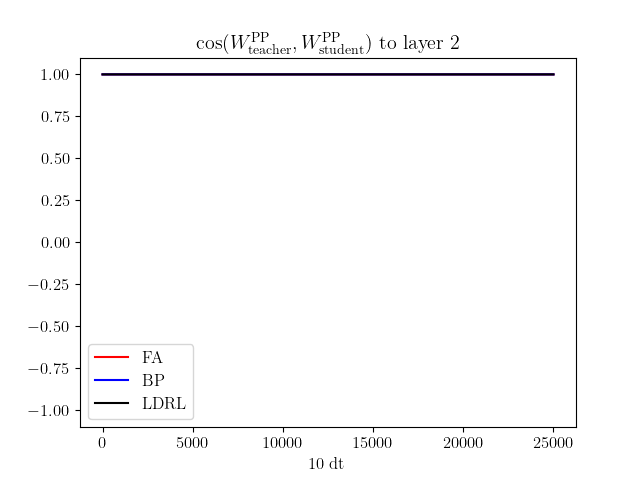

/Users/km/Software/anaconda3/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


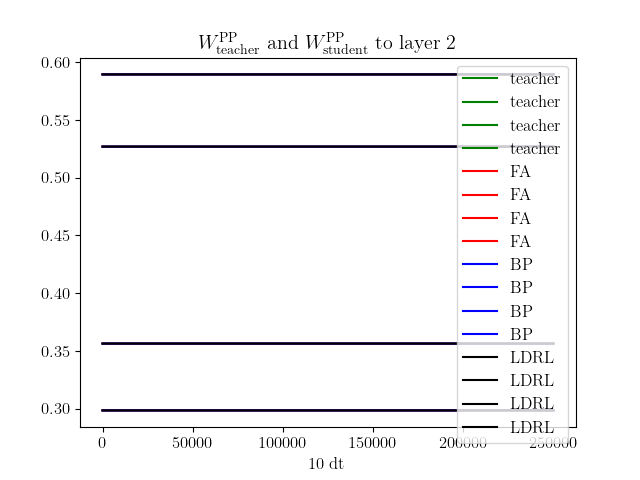

In [296]:
for i in range(len(layers[0:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WPPteacher_WPPstudentFA[i], label="FA", c='red')
    ax.plot(cos_WPPteacher_WPPstudentBP[i], label="BP", c='blue')
    ax.plot(cos_WPPteacher_WPPstudent[i], label="LDRL", c='black')
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{PP}_\mathrm{teacher}, W^\mathrm{PP}_\mathrm{student})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([mc3_teacher.WPP[i].ravel() for WPP in WPP_FA_time_series], label="teacher", c='green')
    ax.plot([WPP[i].ravel() for WPP in WPP_FA_time_series], label="FA", c='red')
    ax.plot([WPP[i].ravel() for WPP in WPP_BP_time_series], label="BP", c='blue')
    ax.plot([WPP[i].ravel() for WPP in WPP_time_series], label="LDRL", c='black')
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$W^\mathrm{PP}_\mathrm{teacher}$ and $W^\mathrm{PP}_\mathrm{student}$ to layer ' + str(i+1))
    # plt.ylim(-1.1,1.1)
    plt.legend()
    plt.show()
    

# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1].T for WPP in WPP_time_series]).ravel(), label="WPP.T")
# ax.plot(np.array(BPP_time_series).ravel(), label="BPP")
# plt.yscale('linear')
# label = 'dt'
# plt.xlabel(label)
# plt.ylabel("B")
# plt.legend()
# # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
# plt.show()

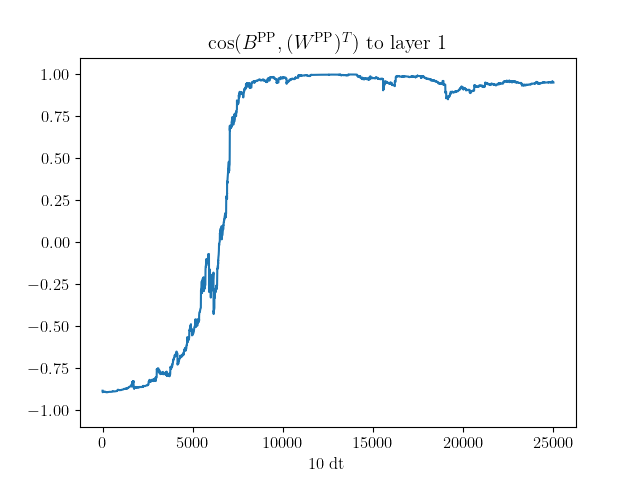

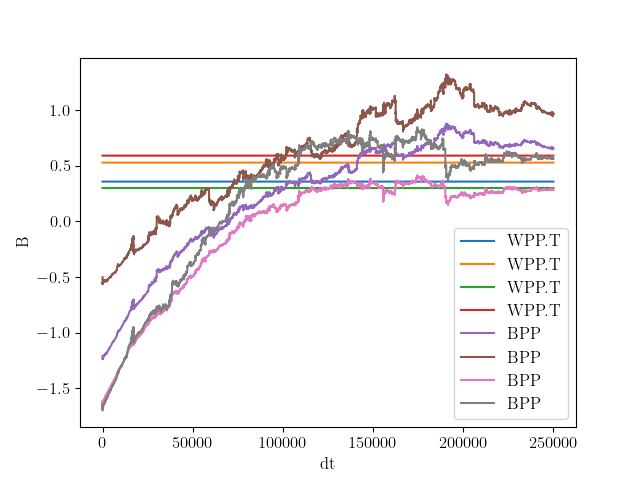

In [297]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WPPtrans_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^T)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    
    fig, ax = plt.subplots()
    ax.plot([WPP[i+1].T.ravel() for WPP in WPP_time_series], label="WPP.T")
    ax.plot([BPP[i].ravel() for BPP in BPP_time_series], label="BPP")
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

Check whether the self-predicting state holds:

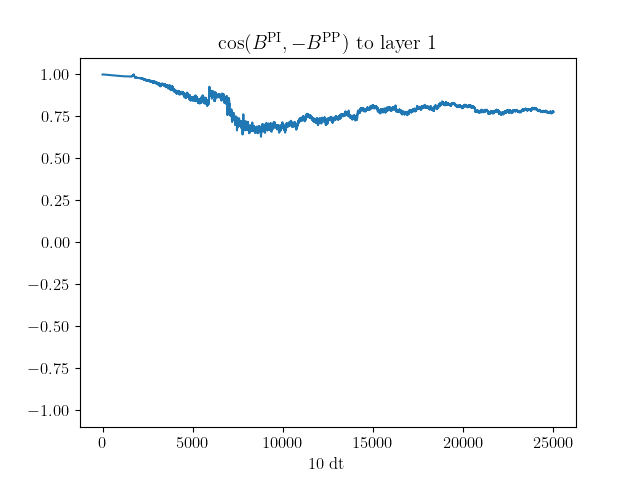

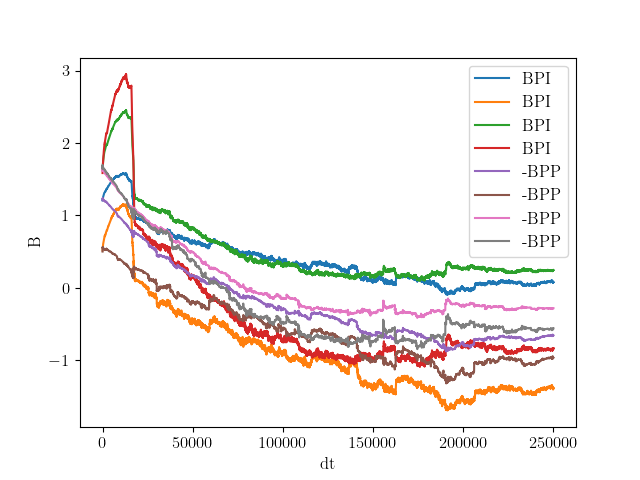

In [298]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_BPI_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([BPI[i].ravel() for BPI in BPI_time_series], label="BPI")
    ax.plot([-BPP[i].ravel() for BPP in BPP_time_series], label="-BPP")
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

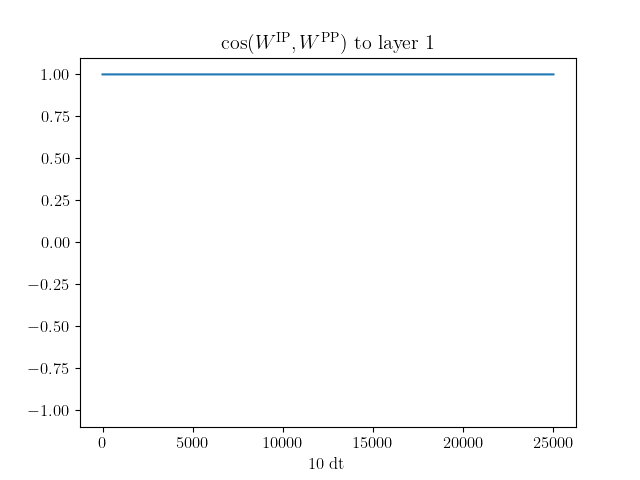

In [299]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WIP_WPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()


# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
# ax.plot(np.array(WIP_time_series).ravel())
# plt.yscale('linear')
# label = 'dt'
# # plt.legend()
# plt.xlabel(label)
# plt.show()